In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mp1 import *

from keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dropout, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.utils import to_categorical
# import keras.utils as np_utils

Using TensorFlow backend.


# Simple classification

In this section we will train a simple linear classifier on shapes data (the data is composed of rectangles, triangles and circles, plus the shapes are centered in the middle of the images).

In [2]:
# Loading the data
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_val, Y_val] = generate_dataset_classification(150, 20)

Creating data:
Creating data:


In [3]:
print('X_train shape : ', X_train.shape)
print('Y_train shape : ', Y_train.shape)

X_train shape :  (300, 5184)
Y_train shape :  (300,)


In [ ]:
# Converting target to categorical
Y_train_one_hot = to_categorical(Y_train)
Y_val_one_hot = to_categorical(Y_val)

We will use both SGD and Adam optimizers to learn the weights of the model.

## Optimizing with SGD

In [ ]:
dense = Dense(3, activation = 'softmax', kernel_initializer='glorot_uniform')
model_sgd = Sequential([dense])
sgd = SGD(lr = 0.01, momentum = 0.8, decay = 1e-6, nesterov = False)
model_sgd.compile(sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_sgd.fit(X_train, Y_train_one_hot, batch_size = 32, validation_data = (X_val, Y_val_one_hot), epochs = 20, verbose = 0);

In [6]:
train_eval = model_sgd.evaluate(X_train, Y_train_one_hot)
val_eval = model_sgd.evaluate(X_val, Y_val_one_hot)
print('Training loss : %.3f' %train_eval[0])
print('Training accuracy : %.3f' %train_eval[1])
print('Validation loss : %.3f' %val_eval[0])
print('Validation accuracy : %.3f' %val_eval[1])

150/150 [==============================] - 0s 101us/step
Training loss : 10.530
Training accuracy : 0.347
Validation loss : 10.745
Validation accuracy : 0.333


The SGD optimizer does not yield a convergence for this task. Let's see if the Adam optimizer can do better

## Optimizing with Adam

In [ ]:
dense = Dense(3, activation = 'softmax', kernel_initializer='glorot_uniform')
model_adam = Sequential([dense])
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay = 1e-8)
model_adam.compile(adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_adam.fit(X_train, Y_train_one_hot, batch_size = 16, validation_data = (X_val, Y_val_one_hot), epochs = 20, verbose = 0);

In [8]:
train_eval = model_adam.evaluate(X_train, Y_train_one_hot)
val_eval = model_adam.evaluate(X_val, Y_val_one_hot)
print('Training loss : %.3f' %train_eval[0])
print('Training accuracy : %.3f' %train_eval[1])
print('Validation loss : %.3f' %val_eval[0])
print('Validation accuracy : %.3f' %val_eval[1])

150/150 [==============================] - 0s 118us/step
Training loss : 0.038
Training accuracy : 1.000
Validation loss : 0.046
Validation accuracy : 1.000


Indeed the Adam optimizer does yield a very good convergence and the model does not overfit the data.

Here is the model summary to see what it looks like.

In [9]:
model_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


Now let's test our well trained model (with Adam) on a generated disk image.

In [ ]:
categories = {0 : 'rectangle', 1 : 'disk', 2 : 'traingle'}
def plot_predict(img, model, title = 'model prediction'):
  
  """
  Description
  -------------
  plot imgage img along with its predicted label
  
  Parameters
  -------------
  img   : 1D np.array of shape (5184,) generated by one of the functions generate_a_rectangle, generate_a_disk or generate_a_triangle.
  model : keras.models.Sequential object, the trained model
  
  Returns
  -------------
  """
  
  img = img.reshape(1, img.shape[0])
  pred = model.predict(img)
  category = categories[pred.argmax()]
  plt.imshow(img.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  plt.title(title + ' : ' + category)
  plt.show()
  

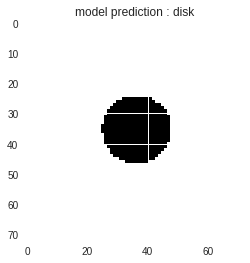

In [11]:
img = generate_a_disk()
plot_predict(img, model_adam)

# Visualization of the solution

Let's see plot the weights to have an idea of the pixels that trigger high activations.

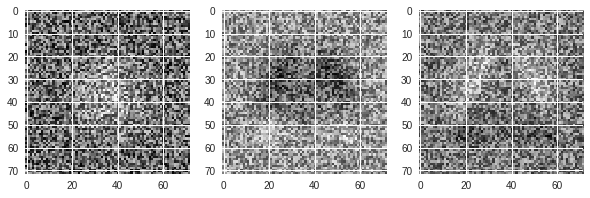

In [12]:
plt.figure(1, figsize=(10, 10))

weights_sgd = model_sgd.get_weights()

plt.subplot(1, 3, 1)
plt.imshow(weights_sgd[0][:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(weights_sgd[0][:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(weights_sgd[0][:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

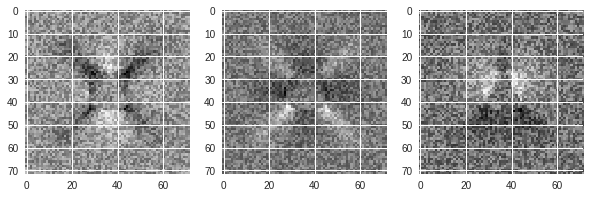

In [13]:
plt.figure(2, figsize=(10, 10))

weights_adam = model_adam.get_weights()

plt.subplot(1, 3, 1)
plt.imshow(weights_adam[0][:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(weights_adam[0][:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(weights_adam[0][:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

The convergence of the model with Adam has yielded weights that are triggered in a pattern corresponding to the three shapes the data has. This is due to the fact that the shapes are all centered in the middle of the images, plus we have a direct link between input and output (no hidden layer is used).

From now on, we will use Adam optimizer only.

# A more difficult classification problem

In this section, we use a more diversified data. Instead of having all shapes centered in the middle of the images, now they are generated in free manner allowing them to move across the images.

Let's start by retraining our simple classifier and see if it will still perform well on this new dataset.

In [14]:
# This time we generate 1000 training samples because of the augmented difficulty of the problem (and to avoid overfitting the more
# models we will potentially use).
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_val, Y_val] = generate_test_set_classification()

Creating data:
Creating data:


Run the following code to visualize a random sample from the new dataset.

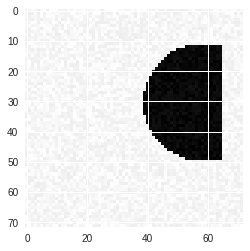

In [16]:
index = np.random.randint(300)
img = X_train[index].reshape(1, X_train[index].shape[0])
plt.imshow(img.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [ ]:
Y_train_one_hot = to_categorical(Y_train)
Y_val_one_hot = to_categorical(Y_val)

In [ ]:
dense = Dense(3, activation = 'softmax', kernel_initializer='glorot_uniform')
model_adam = Sequential([dense])
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay = 1e-8)
model_adam.compile(adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_adam.fit(X_train, Y_train_one_hot, batch_size = 16, validation_data = (X_val, Y_val_one_hot), epochs = 20, verbose = 0);

In [19]:
train_eval = model_adam.evaluate(X_train, Y_train_one_hot)
val_eval = model_adam.evaluate(X_val, Y_val_one_hot)
print('Training loss : %.3f' %train_eval[0])
print('Training accuracy : %.3f' %train_eval[1])
print('Validation loss : %.3f' %val_eval[0])
print('Validation accuracy : %.3f' %val_eval[1])

300/300 [==============================] - 0s 93us/step
Training loss : 0.662
Training accuracy : 0.684
Validation loss : 0.803
Validation accuracy : 0.590


As expected, the model underfits the new data. Thus we need a more complex model, we will involve convolutional layers to learn some levels of abstractions (images features) before feeding them to dense layers.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_train = X_train.astype('float32')

X_val = X_val.reshape(X_val.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_val = X_val.astype('float32')

In [ ]:
conv1 = Conv2D(filters = 8, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
maxpool1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
conv2 = Conv2D(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
maxpool2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
flatten = Flatten()
dense = Dense(64, activation = 'relu', kernel_initializer='glorot_uniform')
classifier = Dense(3, activation = 'softmax', kernel_initializer='glorot_uniform')
layers = [conv1, maxpool1, conv2, maxpool2, flatten, classifier]

model_adam = Sequential(layers)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay = 1e-8)
model_adam.compile(adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_adam.fit(X_train, Y_train_one_hot, batch_size = 32, validation_data = (X_val, Y_val_one_hot), epochs = 20, verbose = 0);

Here is the model summary.

In [115]:
model_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 72, 72, 8)         208       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 36, 36, 16)        3216      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 18, 18, 16)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 15555     
Total params: 18,979
Trainable params: 18,979
Non-trainable params: 0
_________________________________________________________________


We can see that there is a bit of overfitting, but the model still performs very well now on the data. There is no need to add conv or dense layers (high risk of overfitting). We may use dropout or a kernel regularizer, but experiments have shown that they don't yield a great increase in performance in this case

In [22]:
train_eval = model_adam.evaluate(X_train, Y_train_one_hot)
val_eval = model_adam.evaluate(X_val, Y_val_one_hot)
print('Training loss : %.3f' %train_eval[0])
print('Training accuracy : %.3f' %train_eval[1])
print('Validation loss : %.3f' %val_eval[0])
print('Validation accuracy : %.3f' %val_eval[1])

300/300 [==============================] - 0s 143us/step
Training loss : 0.067
Training accuracy : 0.991
Validation loss : 0.207
Validation accuracy : 0.940


# A Regression Problem

In this section, we are confronted to another type of problems. It is a regression where we try to locate the vertices of generated triangles.

In [23]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_val, Y_val] = generate_test_set_regression()

Creating data:
Creating data:


In [ ]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_train = X_train.astype('float32')

X_val = X_val.reshape(X_val.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_val = X_val.astype('float32')

Run the following code to visualize a random sample from the dataset along with its true vertices pixels labeled.

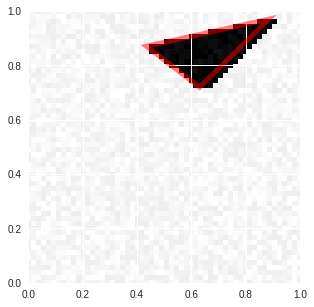

In [25]:
index = np.random.randint(300)

visualize_prediction(X_train[index], Y_train[index])
plt.show()

Here we have to be careful because there is no intrinsic order in the target representation about the vertices pixels, and our model can get confused (in fact it gets confused when experimenting). The idea is then to sort the target pixels with respect to the x-axis for example.

In [ ]:
def sort_u(y):
  
  arange = np.arange(3)
  
  indices_u = np.argsort(y[:, [0, 2, 4]], axis = 1)
  for i in range(y.shape[0]):
    indices_u[i, :] = indices_u[i, :] + arange[indices_u[i, :]]
    indices_v = indices_u[i, :] + 1
    y[i, :] = y[i, :][[indices_u[i, 0], indices_v[0], indices_u[i, 1], indices_v[1], indices_u[i, 2], indices_v[2]]]
    
  
  return y

In [ ]:
Y_train, Y_val = sort_u(Y_train), sort_u(Y_val)

In [ ]:
conv1 = Conv2D(filters = 8, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu') # 72*72
maxpool1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
conv2 = Conv2D(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu') # 36*36
maxpool2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
conv3 = Conv2D(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu') # 18*18
maxpool3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
flatten = Flatten() # 5184
dense = Dense(512, activation = 'relu', kernel_initializer='glorot_uniform')
dropout = Dropout(0.25)

regressor = Dense(6, activation = 'sigmoid', kernel_initializer='glorot_uniform')
layers = [conv1, maxpool1, conv2, maxpool2, conv3, maxpool3, flatten, dense, dropout, regressor]

model_adam = Sequential(layers)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay = 1e-8)
model_adam.compile(adam, loss = 'mean_absolute_error')
model_adam.fit(X_train, Y_train, batch_size = 32, validation_data = (X_val, Y_val), epochs = 70, verbose = 0);

Notice that we changed the mean_squared_error loss to mean_absolute_error, we did it because the predictions are all in $[0, 1]$ range, the values get small very fast and the loss gets stuck. The $[0, 1]$ range also led us to use a sigmoid as the last fully connected layer activation, and indeed it yields better results compared to a simple linear activation.

Here is the model summary:

In [29]:
model_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 72, 72, 8)         208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 16)        3216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 16)        6416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1296)              0         
__________

In [32]:
train_eval = model_adam.evaluate(X_train, Y_train)
val_eval = model_adam.evaluate(X_val, Y_val)
print('Training loss : %.3f' %train_eval)
print('Validation loss : %.3f' %val_eval)

300/300 [==============================] - 0s 153us/step
Training loss : 0.015
Validation loss : 0.043


The model has a decent convergence and does not overtif the data too much.

Now let's test the model.

In [ ]:
Y_val_pred = model_adam.predict(X_val)
Y_train_pred = model_adam.predict(X_train)

Run the following cell to sample a random image along with its predicted vertices pixels from the training set.

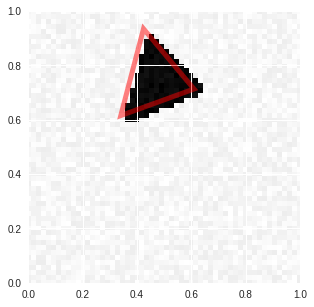

In [39]:
index = np.random.randint(1000)
visualize_prediction(X_train[index], Y_train_pred[index])
plt.show()

Run the following cell to sample a random image along with its predicted vertices pixels from the validation set.

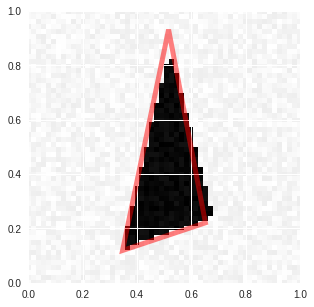

In [37]:
index = np.random.randint(300)
visualize_prediction(X_val[index], Y_val_pred[index])
plt.show()

# Image denoising

This section presents a different task. The goal here is to denoise images. So we will start by generating pairs of clean and noisy images to train an autoencoder network before testing on a similarly generated validation set.

The following functions help in generating the datasets of interest.

In [ ]:
def generate_pair_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, 0.), generate_a_drawing(figsize, U, V, noise)


def generate_pair_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, 0.), generate_a_drawing(figsize, U, V, noise)

def generate_pair_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, 0.), generate_a_drawing(figsize, U, V, noise)

def generate_dataset_pairs(nb_samples, noise_range = [20, 40], free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        noise = np.random.uniform(noise_range[0], noise_range[1])
        if category == 0:
            X[i], X_noise[i] = generate_pair_rectangle(noise, free_location)
            
        elif category == 1:
            X[i], X_noise[i] = generate_pair_disk(noise, free_location)
            
        else:
            X[i], X_noise[i] = generate_pair_triangle(noise, free_location)
            
        X[i], X_noise[i] = X[i]/255, (X_noise[i] + noise)/(255 + 2*noise)
            
    return [X, X_noise]

The noisy datasets we generate are corrupted by noise of random amplitude between $100$ and $200$

In [41]:
[X, X_noise] = generate_dataset_pairs(1000, noise_range = [100, 200], free_location = True)
[X_val, X_noise_val] = generate_dataset_pairs(300, noise_range = [100, 200], free_location = True)

Creating data:
Creating data:


Run the following cell to visualize a random pair from the training set.

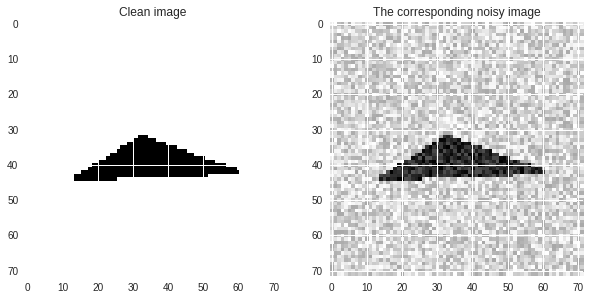

In [42]:
index = np.random.randint(1000)

plt.figure(3, (10, 10))

plt.subplot(1, 2, 1)
plt.imshow(X[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Clean image')

plt.subplot(1, 2, 2)
plt.imshow(X_noise[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('The corresponding noisy image')
plt.show();

In [ ]:
X = X.reshape(X.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X = X.astype('float32')

X_val = X_val.reshape(X_val.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_val = X_val.astype('float32')

X_noise = X_noise.reshape(X_noise.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_noise = X_noise.astype('float32')

X_noise_val = X_noise_val.reshape(X_noise_val.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_noise_val = X_noise_val.astype('float32')

In [ ]:
# Encoding phase.
conv1 = Conv2D(filters = 8, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
maxpool1 = MaxPooling2D()
conv2 = Conv2D(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
maxpool2 = MaxPooling2D()
conv3 = Conv2D(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
maxpool3 = MaxPooling2D()

# Decoding phase.
deconv1 = Conv2DTranspose(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
upsample1 = UpSampling2D()
deconv2 = Conv2DTranspose(filters = 16, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
upsample2 = UpSampling2D()
deconv3 = Conv2DTranspose(filters = 8, strides = 1, kernel_size = (5, 5), padding = 'same', activation = 'relu')
upsample3 = UpSampling2D()

decoder = Conv2DTranspose(filters = 1, kernel_size = (5, 5), activation='sigmoid', padding='same')

layers = [conv1, maxpool1, conv2, maxpool2, conv3, maxpool3, deconv1, upsample1, deconv2, upsample2, deconv3, upsample3, decoder]

hoorglass_adam = Sequential(layers)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay = 1e-8)
hoorglass_adam.compile(adam, loss = 'binary_crossentropy')
hoorglass_adam.fit(X_noise, X, batch_size = 32, validation_data = (X_noise_val, X_val), epochs = 100, verbose = 0);

Notice that we used sigmoid as the last layer activation along with binary cross-entropy loss to force binary values since clean images are black shapes in white background.

Here is the model summary.

In [45]:
hoorglass_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 72, 72, 8)         208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 16)        3216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 16)        6416      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 16)          6416      
__________

In [46]:
train_eval = hoorglass_adam.evaluate(X_noise, X)
val_eval = hoorglass_adam.evaluate(X_noise_val, X_val)
print('Training loss : %.3f' %train_eval)
print('Validation loss : %.3f' %val_eval)

300/300 [==============================] - 0s 183us/step
Training loss : 0.006
Validation loss : 0.007


According to the evaluation above, the model converges well and does not overfit the data.

Now let's see the model in action.

In [ ]:
X_noise_pred = hoorglass_adam.predict(X_noise)
X_noise_val_pred = hoorglass_adam.predict(X_noise_val)

Run the following cell to denoise a random image for the training set.

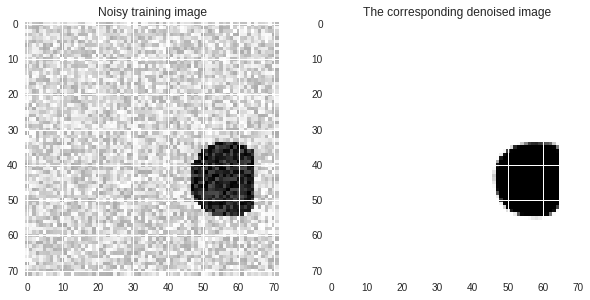

In [48]:
index = np.random.randint(0, 1000)
im, im_noisy = X_noise[index, :, :, 0], X_noise_pred[index, :, :, 0]
plt.figure(4, (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Noisy training image')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('The corresponding denoised image')
plt.show()

Run the following cell to denoise a random image for the validation set.

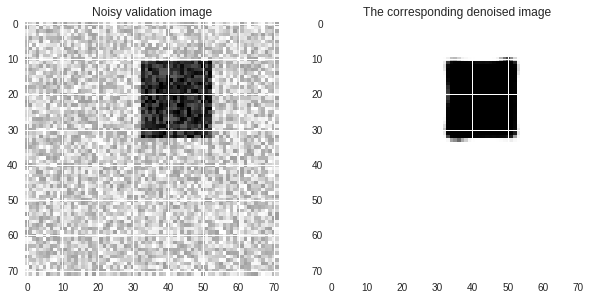

In [52]:
index = np.random.randint(0, 300)
im, im_noisy = X_noise_val[index, :, :, 0], X_noise_val_pred[index, :, :, 0]
plt.figure(4, (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Noisy validation image')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('The corresponding denoised image')
plt.show()

From the examples above, we clearly see that the model performs very well on both training and validation datasets, thus avoiding overfitting.